# Импорты

In [ ]:
import torch
import numpy as np
import torchvision
from tqdm import tqdm
from mlp import Perceptron
from matplotlib import gridspec
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Country211
from sklearn.metrics import classification_report

# Набор данных

In [ ]:
# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True,
                                                  transform=transforms.Compose([transforms.ToTensor(), ]))

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True,
                                                 transform=transforms.Compose([transforms.ToTensor(), ]))

100%|██████████| 26421880/26421880 [00:01<00:00, 13645495.07it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199924.55it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3737275.80it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21898861.05it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Устройство для выполнения

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Всякие полезные функции для обучения/теста/отрисовки

In [ ]:
def tester(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred, real = [], []
    for x, y in generator:
        x = x.view([-1, 784]).to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    report = classification_report(real, pred, output_dict=True)
    return report['macro avg']['f1-score'], classification_report(real, pred)

def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in range(epochs):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64,
                                              shuffle=True)
        for x, y in generator:
            optimizer.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

In [ ]:
def get_dependency_2d(param1: list[int], result: list[int], name_param1: str):
    plt.title(f'Зависимость метрики от {name_param1}')
    plt.plot(param1, result)

# MLP без инициализации

In [ ]:
model = Perceptron(num_layers=3)
model.to(device)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (layer2): Linear(in_features=64, out_features=64, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
trainer(model=model,
        dataset=train_dataset,
        loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
        epochs=4)

macro_avg, report = tester(model, test_dataset)
print(report)

 99%|█████████▉| 930/938 [00:11<00:00, 83.94it/s]


## Посмотрим теперь на график зависимости лосса от числа слоев на train/test датасете

In [ ]:
num_layers = range(2,20,2)
results = []
for num in tqdm(num_layers):
    model = Perceptron(num_layers=num)
    model.to(device)
    trainer(
          model=model,
          dataset=train_dataset,
          loss_function=torch.nn.CrossEntropyLoss(),
          optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
          epochs=4
          )
    macro_avg, report = tester(model, test_dataset)
    results.append(macro_avg)

 56%|█████▌    | 5/9 [04:11<03:30, 52.62s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/pyth

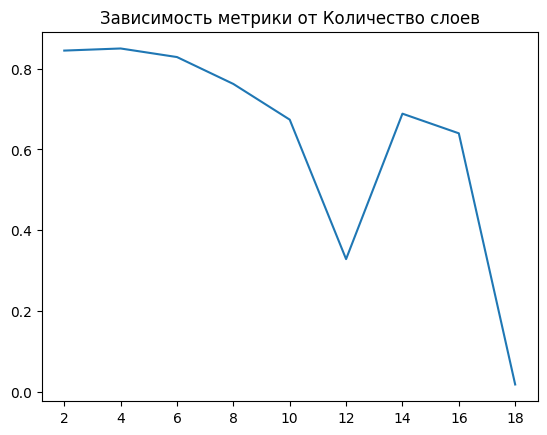

In [ ]:
get_dependency_2d(num_layers, results, 'Количество слоев')

**Вывод:**

Видим, что при большом количестве слоев в сети, качество модели ухудшается.

Почему так происходит?

Потому что при большом количестве слоев градиенты, вычисляемые во время обратного распространения ошибки, могут становиться слишком маленькими или слишком большими, что затрудняет обучение.

Это может приводить к тому, что веса в нижних слоях практически не обновляются или обновляются слишком сильно, что ухудшает обучение.



# MLP с инициализацией Xavier

In [ ]:
num_layers = range(2,20,2)
results = []
for num in tqdm(num_layers):
    model = Perceptron(num_layers=num, init_weights=True)
    model.to(device)
    trainer(
          model=model,
          dataset=train_dataset,
          loss_function=torch.nn.CrossEntropyLoss(),
          optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
          epochs=4
          )
    macro_avg, report = tester(model, test_dataset)
    results.append(macro_avg)

 56%|█████▌    | 5/9 [02:58<02:25, 36.44s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/pyth

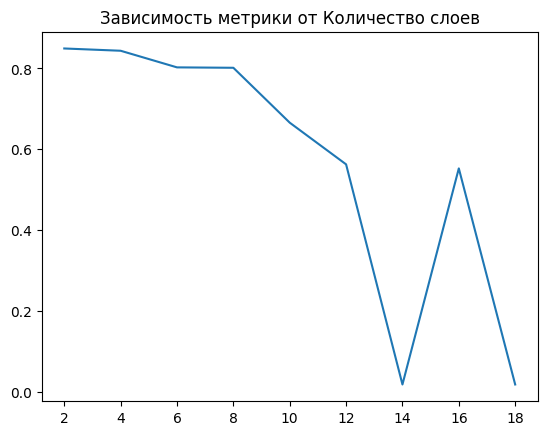

In [ ]:
get_dependency_2d(num_layers, results, 'Количество слоев')

# MLP с пакетной нормализацией

In [ ]:
num_layers = range(2,20,2)
results = []
for num in tqdm(num_layers):
    model = Perceptron(num_layers=3, init_weights=True, batch_norm=True)
    model.to(device)
    trainer(
          model=model,
          dataset=train_dataset,
          loss_function=torch.nn.CrossEntropyLoss(),
          optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
          epochs=4
          )
    macro_avg, report = tester(model, test_dataset)
    results.append(macro_avg)

100%|██████████| 9/9 [05:15<00:00, 35.04s/it]


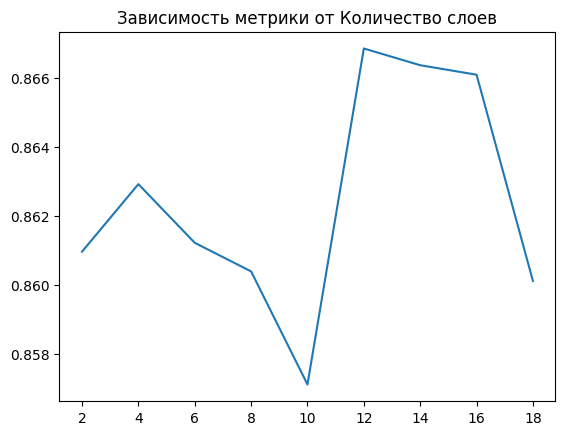

In [ ]:
get_dependency_2d(num_layers, results, 'Количество слоев')